We experimented with gender-dependent formants here in order to compare the performance of the best traditional machine learning models against the gender-independent version.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

# packages for models
import sklearn
from sklearn.svm import SVC
import skelm 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from xgboost import XGBClassifier
from hmmlearn import hmm

# dimensionality reduction
from sklearn.decomposition import PCA
from featurewiz import FeatureWiz

# import own functions
from ipynb.fs.full.Functions import load_train_test_data, model_eval, run_gridsearchCV, load_model, feature_importance

pd.set_option('display.max_columns', None)
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

# SVM 

## Dimensionality Reduction (Feature Selection)
For this, we also load the whole dataset with all statistics.

In [2]:
# load the data
df_all_stats = pd.read_pickle('../results/female_male_differentiation/df_prep_numerical_only_all_stats.pkl')
print(df_all_stats.columns)

Index(['duration', 'mean', 'median', 'max', 'min', 'var', 'std',
       'speaking_rate', 'articulation_rate', 'asd',
       ...
       'value_rising_energy_iqr', 'value_falling_energy_iqr',
       'duration_rising_pitch_iqr', 'duration_falling_pitch_iqr',
       'value_rising_pitch_iqr', 'value_falling_pitch_iqr', 'skew_log_pitch',
       'range_log_pitch', 'range_log_energy', 'label'],
      dtype='object', length=596)


### 1) PCA

93
[0.14145527 0.12560323 0.05199219 0.04162009 0.0356041  0.03101128
 0.02716527 0.02066524 0.01946782 0.01841813 0.01559138 0.01496201
 0.01428525 0.01372732 0.01293254 0.0124938  0.01125364 0.0106804
 0.01036109 0.00978716 0.00876704 0.00821898 0.0079411  0.0076914
 0.00751193 0.00711541 0.00681546 0.00668045 0.00646148 0.00617303
 0.00598171 0.00560764 0.00546086 0.00535999 0.00519781 0.00497456
 0.00471911 0.00467046 0.00454272 0.00441232 0.0043091  0.00418287
 0.00412046 0.00399658 0.00395172 0.003814   0.0036486  0.00358959
 0.00356587 0.00348369 0.00341227 0.00331635 0.00320196 0.00314999
 0.00312487 0.00308481 0.0029417  0.00290464 0.00284419 0.00281463
 0.00273431 0.00263857 0.00258798 0.00255181 0.00253478 0.00242935
 0.0024147  0.00235155 0.00230998 0.00228053 0.00224791 0.0021586
 0.0021542  0.00212958 0.00209343 0.00207396 0.00203857 0.00200966
 0.00194629 0.00190114 0.00188306 0.00185325 0.00183186 0.00180693
 0.00177502 0.00175646 0.00172674 0.00170308 0.00168391 0.0016

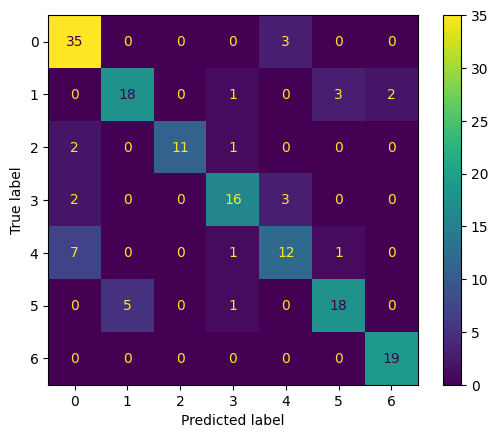


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [3]:
# with all statistical features

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_all_stats, verbose=False, test_size=0.3)

# apply PCA to the data
pca = PCA(0.9)
X_train = pca.fit_transform(X_train)

# apply to test set
X_test = pca.transform(X_test)

print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

### 2) Featurewiz

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (374, 596)
#### Single_Label Multi_Classification problem ####
No test data filename give

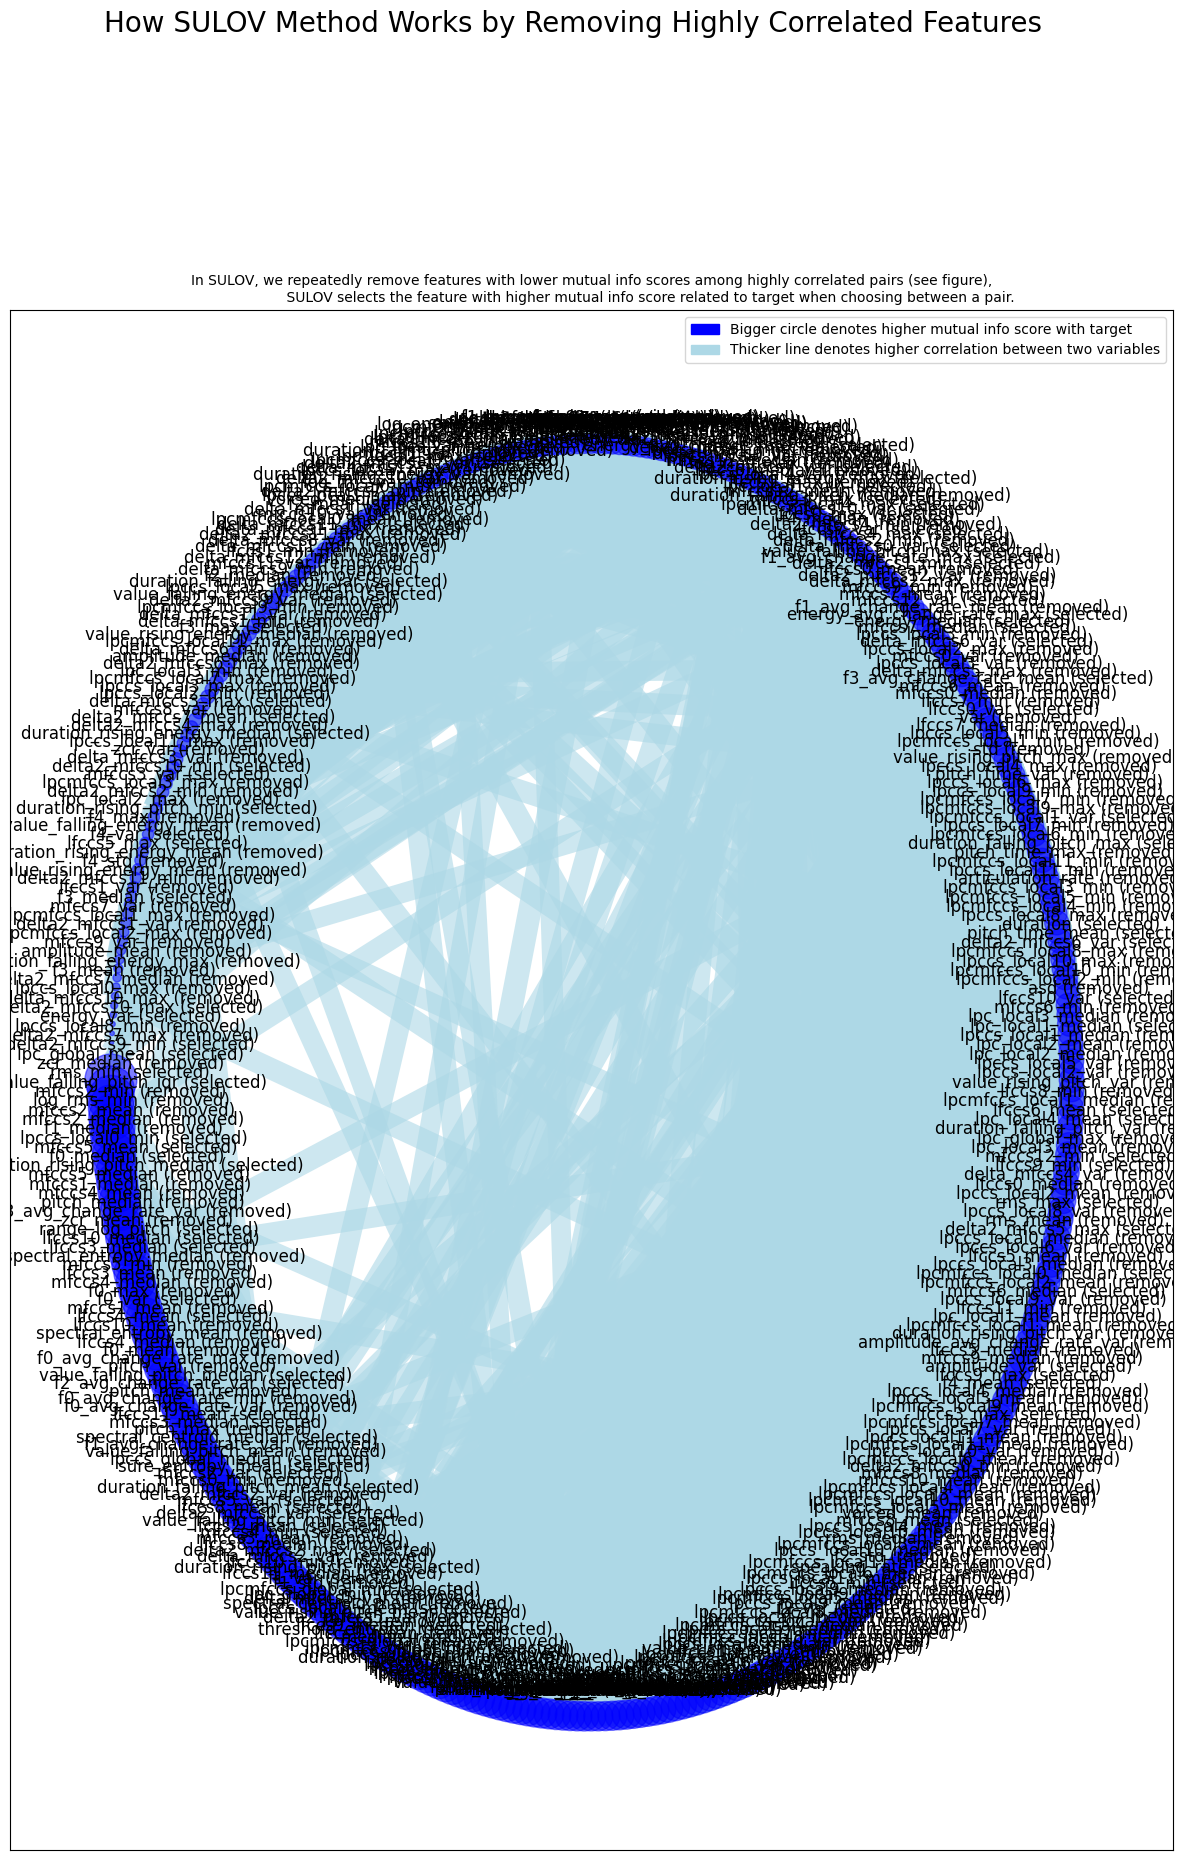

Time taken for SULOV method = 14 seconds
    Adding 0 categorical variables to reduced numeric variables  of 297
Finally 297 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 119 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
    Number of booster rounds = 100
            Time taken for regular XGBoost feature selection = 2 seconds
            Time taken for regular XGBoost feature selection = 2 seconds
            Time taken for regular XGBoost feature selection = 2 seconds
            Time taken for regular XGBoost feature selection = 2 seconds
            Time taken for regular XGBoost feature selection = 1 secon

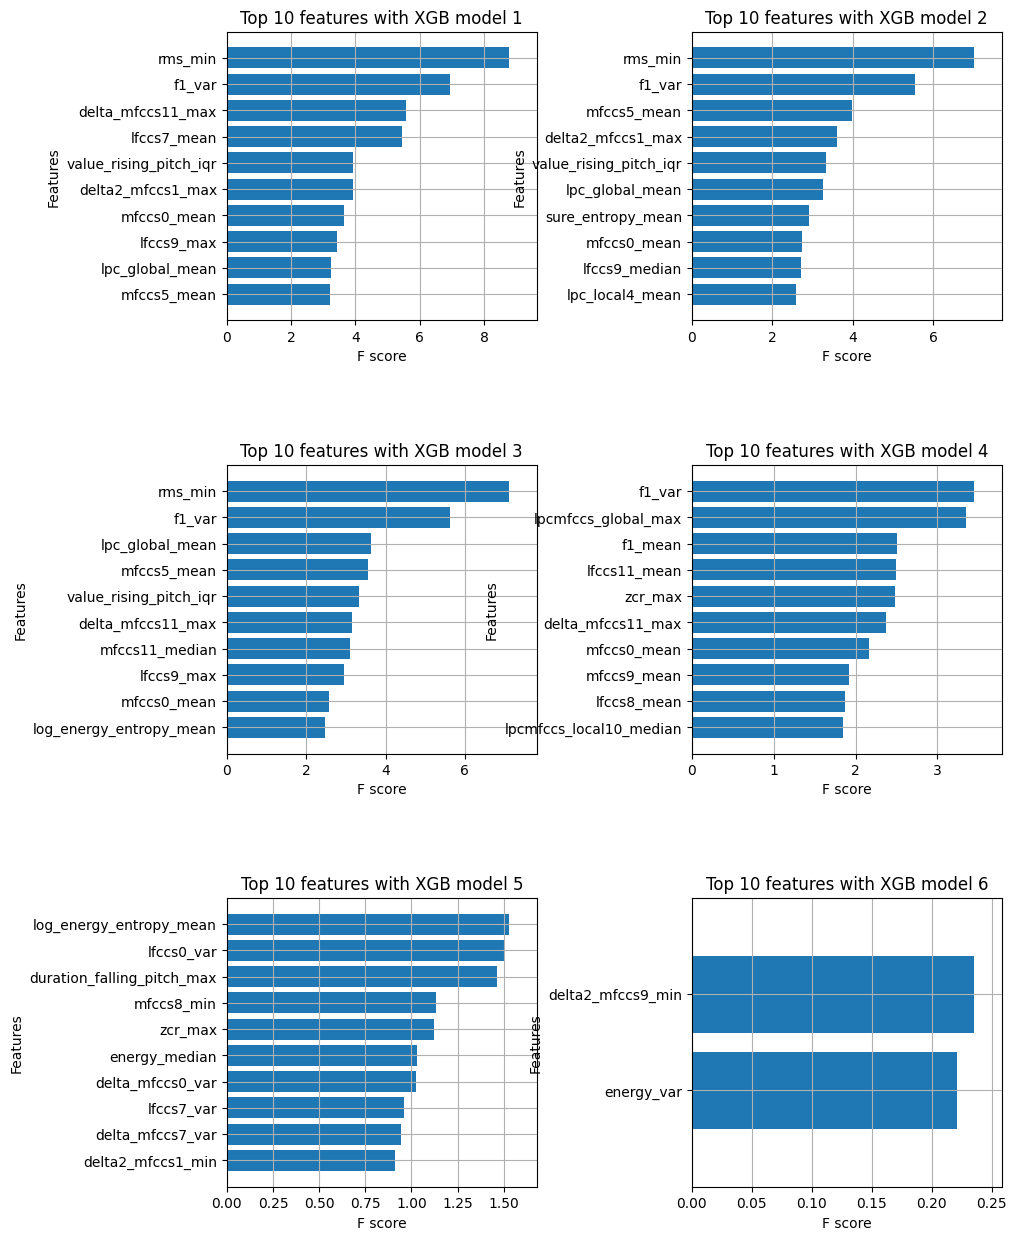

    Completed XGBoost feature selection in 3 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 218 important features. Too many to print...
Total Time taken for featurewiz selection = 26 seconds
Output contains a list of 218 important features and a train dataframe
    Time taken to create entire pipeline = 28 second(s)


In [10]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_all_stats, verbose=False, test_size=0.3)

# automatic feature selection using featurewiz package
fwiz = FeatureWiz(corr_limit=0.7, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)

X_train = fwiz.fit_transform(X_train, y_train)
X_test = fwiz.transform(X_test)

# get list of selected features
selected_features = fwiz.features  

In [11]:
# save most important features
with open('../results/female_male_differentiation/most_important_features_70_30_split_215.pkl', 'wb') as f:
    pickle.dump(selected_features, f)


Evaluation: f1_score
99.00% for the train data
80.56% for the test data

Evaluation: accuracy_score
98.93% for the train data
81.37% for the test data

Evaluation: precision_score
99.15% for the train data
83.88% for the test data

Evaluation: recall_score
98.88% for the train data
79.35% for the test data

Evaluation: confusion_matrix of test predictions


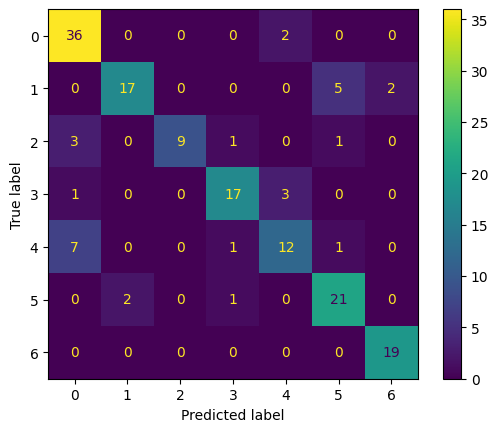


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [12]:
# train the model
svm_model = SVC(random_state=0)
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

In [13]:
# save model
pickle.dump(svm_model, open('../results/models/SVC_f1_macro_best_model_most_important215_fmd.pkl', 'wb'))

# Paper 2
### Liu et al. (2018) "Speech emotion recognition based on feature selection and extreme learning machine decision tree"

In [14]:
# read saved dataframe
df = pd.read_pickle('../results/female_male_differentiation/df_prep_numerical_only_all_stats.pkl')

# feature selection
df_paper2 = df[['f0_max', 'f0_var', 'amplitude_max', 'energy_mean', 'amplitude_mean', 'zcr_mean', 'speaking_rate', 
                'spectral_centroid_mean', 'spectral_centroid_mean', 'f1_max', 'f1_mean', 'f1_std', 'f2_max', 'f2_mean', 
                'f2_std', 'f3_max', 'f3_std', 'f3_mean', 'f0_avg_change_rate_mean', 'energy_avg_change_rate_mean', 
                'amplitude_avg_change_rate_mean', 'f1_avg_change_rate_mean', 'f2_avg_change_rate_mean', 
                'f3_avg_change_rate_mean', 'label']]
df_paper2 = pd.concat([df_paper2, df.filter(regex='^(delta|mfccs|lfccs)\w+_mean$')], axis=1)
print(f'The dataframe has {len(df_paper2.columns)} columns.')
df_paper2.columns

The dataframe has 76 columns.


Index(['f0_max', 'f0_var', 'amplitude_max', 'energy_mean', 'amplitude_mean',
       'zcr_mean', 'speaking_rate', 'spectral_centroid_mean',
       'spectral_centroid_mean', 'f1_max', 'f1_mean', 'f1_std', 'f2_max',
       'f2_mean', 'f2_std', 'f3_max', 'f3_std', 'f3_mean',
       'f0_avg_change_rate_mean', 'energy_avg_change_rate_mean',
       'amplitude_avg_change_rate_mean', 'f1_avg_change_rate_mean',
       'f2_avg_change_rate_mean', 'f3_avg_change_rate_mean', 'label',
       'mfccs0_mean', 'mfccs1_mean', 'mfccs2_mean', 'mfccs3_mean',
       'mfccs4_mean', 'mfccs5_mean', 'mfccs6_mean', 'mfccs7_mean',
       'mfccs8_mean', 'mfccs9_mean', 'mfccs10_mean', 'mfccs11_mean',
       'mfccs12_mean', 'delta_mfccs0_mean', 'delta_mfccs1_mean',
       'delta_mfccs2_mean', 'delta_mfccs3_mean', 'delta_mfccs4_mean',
       'delta_mfccs5_mean', 'delta_mfccs6_mean', 'delta_mfccs7_mean',
       'delta_mfccs8_mean', 'delta_mfccs9_mean', 'delta_mfccs10_mean',
       'delta_mfccs11_mean', 'delta_mfccs12_me

In [15]:
# create train/test split
X_train, X_test, y_train, y_test = load_train_test_data(df_paper2, test_size=0.3)

A snippet of the data:


,f0_max,f0_var,amplitude_max,energy_mean,amplitude_mean,zcr_mean,speaking_rate,spectral_centroid_mean,spectral_centroid_mean,f1_max,f1_mean,f1_std,f2_max,f2_mean,f2_std,f3_max,f3_std,f3_mean,f0_avg_change_rate_mean,energy_avg_change_rate_mean,amplitude_avg_change_rate_mean,f1_avg_change_rate_mean,f2_avg_change_rate_mean,f3_avg_change_rate_mean,mfccs0_mean,mfccs1_mean,mfccs2_mean,mfccs3_mean,mfccs4_mean,mfccs5_mean,mfccs6_mean,mfccs7_mean,mfccs8_mean,mfccs9_mean,mfccs10_mean,mfccs11_mean,mfccs12_mean,delta_mfccs0_mean,delta_mfccs1_mean,delta_mfccs2_mean,delta_mfccs3_mean,delta_mfccs4_mean,delta_mfccs5_mean,delta_mfccs6_mean,delta_mfccs7_mean,delta_mfccs8_mean,delta_mfccs9_mean,delta_mfccs10_mean,delta_mfccs11_mean,delta_mfccs12_mean,delta2_mfccs0_mean,delta2_mfccs1_mean,delta2_mfccs2_mean,delta2_mfccs3_mean,delta2_mfccs4_mean,delta2_mfccs5_mean,delta2_mfccs6_mean,delta2_mfccs7_mean,delta2_mfccs8_mean,delta2_mfccs9_mean,delta2_mfccs10_mean,delta2_mfccs11_mean,delta2_mfccs12_mean,lfccs0_mean,lfccs1_mean,lfccs2_mean,lfccs3_mean,lfccs4_mean,lfccs5_mean,lfccs6_mean,lfccs7_mean,lfccs8_mean,lfccs9_mean,lfccs10_mean,lfccs11_mean
383,1.525845,1.206094,0.760068,0.317074,0.909308,1.338426,0.456822,0.540177,0.540177,0.293573,0.072718,-0.395493,-0.257018,1.112591,0.032052,0.786649,-0.717739,0.587064,-0.407227,0.062360,0.929839,-0.153563,0.091687,-0.097761,0.435260,-0.997914,-0.237505,-0.328507,-0.964237,-0.916971,-0.436511,0.485352,-1.466484,-1.676938,-0.623160,-1.545878,0.131605,0.918316,0.581176,-0.636879,-0.511475,-0.487945,-0.140095,0.067913,0.143268,-0.492649,0.283545,-1.486673,0.033260,0.945551,1.103540,-1.694898,-0.887902,0.367715,-1.319240,-0.266879,-0.330664,0.366629,-0.167171,-0.967311,0.722167,1.282151,-0.898049,0.791651,-0.906900,-0.837526,-0.443766,-0.097478,-0.872068,0.682026,0.043037,-0.279696,-0.972006,-1.743858,-0.245983
180,-1.575226,-1.206448,-1.321738,1.235771,-0.586936,-1.931865,0.209623,-0.313100,-0.313100,-0.066663,0.885010,1.962660,1.074428,-0.643153,2.359061,0.283985,1.812086,0.579985,-0.407227,0.080439,0.897814,-0.639382,0.012484,-0.347691,0.253539,1.680797,1.128980,-0.061849,1.428238,3.023523,2.774592,-0.100087,0.986410,0.898155,0.887842,0.445738,1.033796,0.215660,-0.028897,0.224939,0.732799,-0.304120,-0.812887,0.069136,0.217385,0.178223,-0.535975,-0.482405,0.202800,-0.120524,1.173464,0.555142,-0.256760,0.588258,-0.226420,-1.059436,-0.495234,-0.132786,-0.550215,-0.733214,-0.872256,-0.322407,0.267054,-0.361862,0.530331,1.496105,0.999877,1.451860,0.761814,-0.691929,-0.583639,0.495418,0.111098,1.085186,2.457121
447,-1.119185,-0.900378,-2.032401,0.816171,0.630640,0.968309,1.624222,1.322148,1.322148,1.864836,1.397012,2.650102,0.040210,0.599863,1.979494,0.058412,2.636206,0.814512,-0.407227,2.554648,-0.697488,-0.548406,-1.092635,-0.400780,3.016815,-0.321927,1.210915,-0.279866,0.799196,2.039154,1.455036,1.522504,0.776596,0.919846,-0.031569,-0.158161,-0.542489,0.831870,-0.508707,0.799558,-0.592613,-1.645572,-0.361632,-0.717345,-1.977946,-0.992548,0.335843,1.205088,1.345985,0.998242,0.441185,1.287843,-0.517041,-0.231525,-1.044098,-1.240137,-0.881396,-0.566533,-0.589650,0.211228,-0.627407,-1.292787,0.686653,3.159583,-1.583903,0.015513,1.273022,0.182458,0.625249,-0.752866,0.068314,0.522608,0.447433,0.594748,0.468281
409,-0.675941,-0.541462,0.760068,0.392074,-0.031257,0.659251,-0.056061,0.435324,0.435324,-1.200098,0.257034,-0.977020,-1.221028,-1.154558,-1.825122,-1.466755,-1.380206,-0.970252,-0.407227,0.061329,-1.197594,-0.552490,-1.210498,-0.701381,-0.263610,-0.346001,-1.416076,-0.967379,-0.623749,-0.085471,-0.440442,-0.969464,0.178537,0.392534,0.864496,-0.489883,-0.632987,-1.461906,-1.001108,-1.214918,-2.449306,0.401876,0.944171,0.986778,-0.562346,2.536392,3.197237,-0.082637,0.287874,-0.569824,-1.810128,0.973143,2.856536,-0.605752,0.895440,0.375045,4.339030,3.864099,-3.076622,1.347338,-1.445572,-1.416653,-1.053647,-0.342277,0.468572,-0.555313,-0.837950,-0.871011,-0.288034,-2.548539,-0.675005,0.293606,-1.544340,-0.622789,-0.3

There are 374 entries with 75 columns in the training data.
There are 161 entries with 75 columns in the testing data.


## ELM Decision Tree
Extreme Learning Machines are supposedly really good for generalization and fast training with one hidden layer only and many hidden units. From "High Performance Extreme Learning Machines: A Complete Toolbox for Big Data Applications" in IEEE Access. http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=7140733&newsearch=true&queryText=High%20Performance%20Extreme%20Learning%20Machines
<br> Using scikit-elm: https://scikit-elm.readthedocs.io/en/latest/generated/skelm.ELMClassifier.html#skelm.ELMClassifier


Evaluation: f1_score
95.29% for the train data
63.81% for the test data

Evaluation: accuracy_score
95.19% for the train data
65.22% for the test data

Evaluation: precision_score
95.84% for the train data
64.68% for the test data

Evaluation: recall_score
94.94% for the train data
63.56% for the test data

Evaluation: confusion_matrix of test predictions


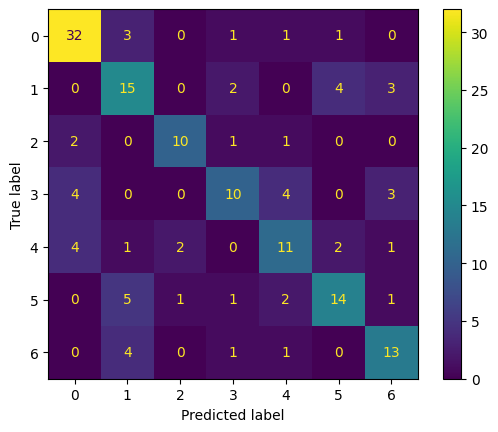


Hard cases for the model:

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']



In [16]:
# with scikit-elm
elm = skelm.ELMClassifier(random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
94.58% for the train data
67.06% for the test data

Evaluation: accuracy_score
94.65% for the train data
68.32% for the test data

Evaluation: precision_score
95.10% for the train data
67.92% for the test data

Evaluation: recall_score
94.25% for the train data
66.77% for the test data

Evaluation: confusion_matrix of test predictions


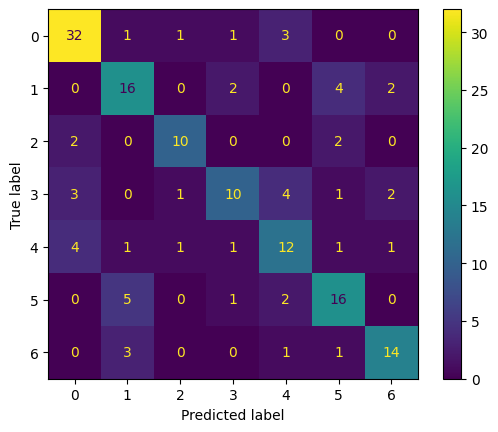


Hard cases for the model:

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [17]:
elm = skelm.ELMClassifier(ufunc='sigm', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
98.31% for the train data
74.44% for the test data

Evaluation: accuracy_score
98.40% for the train data
75.78% for the test data

Evaluation: precision_score
98.61% for the train data
75.58% for the test data

Evaluation: recall_score
98.04% for the train data
73.98% for the test data

Evaluation: confusion_matrix of test predictions


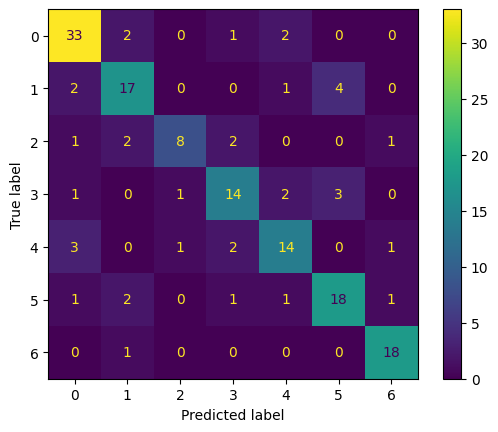


Hard cases for the model:



In [18]:
elm = skelm.ELMClassifier(pairwise_metric='euclidean', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
91.67% for the train data
78.47% for the test data

Evaluation: accuracy_score
91.98% for the train data
79.50% for the test data

Evaluation: precision_score
93.12% for the train data
81.63% for the test data

Evaluation: recall_score
90.88% for the train data
77.22% for the test data

Evaluation: confusion_matrix of test predictions


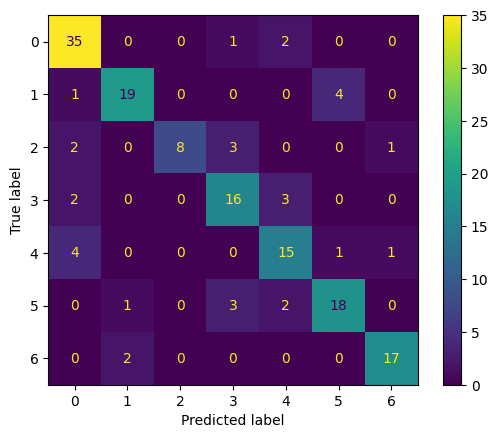


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']



In [19]:
elm = skelm.ELMClassifier(pairwise_metric='cosine', random_state=0) # also achieved from n_neurons=74 (n_samples / 5 
                                                                    # which is often chosen as default) onwards
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
94.89% for the train data
69.49% for the test data

Evaluation: accuracy_score
94.92% for the train data
71.43% for the test data

Evaluation: precision_score
95.74% for the train data
72.93% for the test data

Evaluation: recall_score
94.28% for the train data
68.71% for the test data

Evaluation: confusion_matrix of test predictions


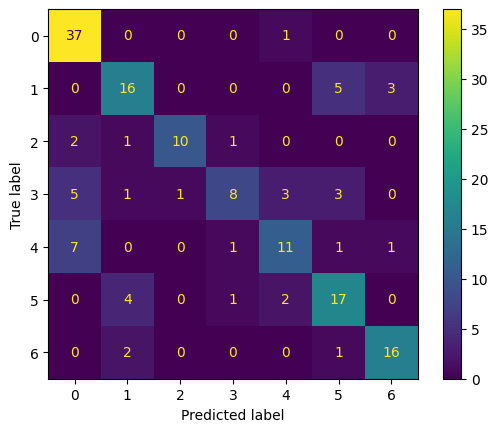


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [20]:
# compare with SVM
svm_model = SVC(random_state=0)
svm_model.fit(X_train, y_train)
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

### After Feature Selection

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
You have duplicate column names in your data set. Removing duplicate columns now...
    Loaded train data. Shape = (374,

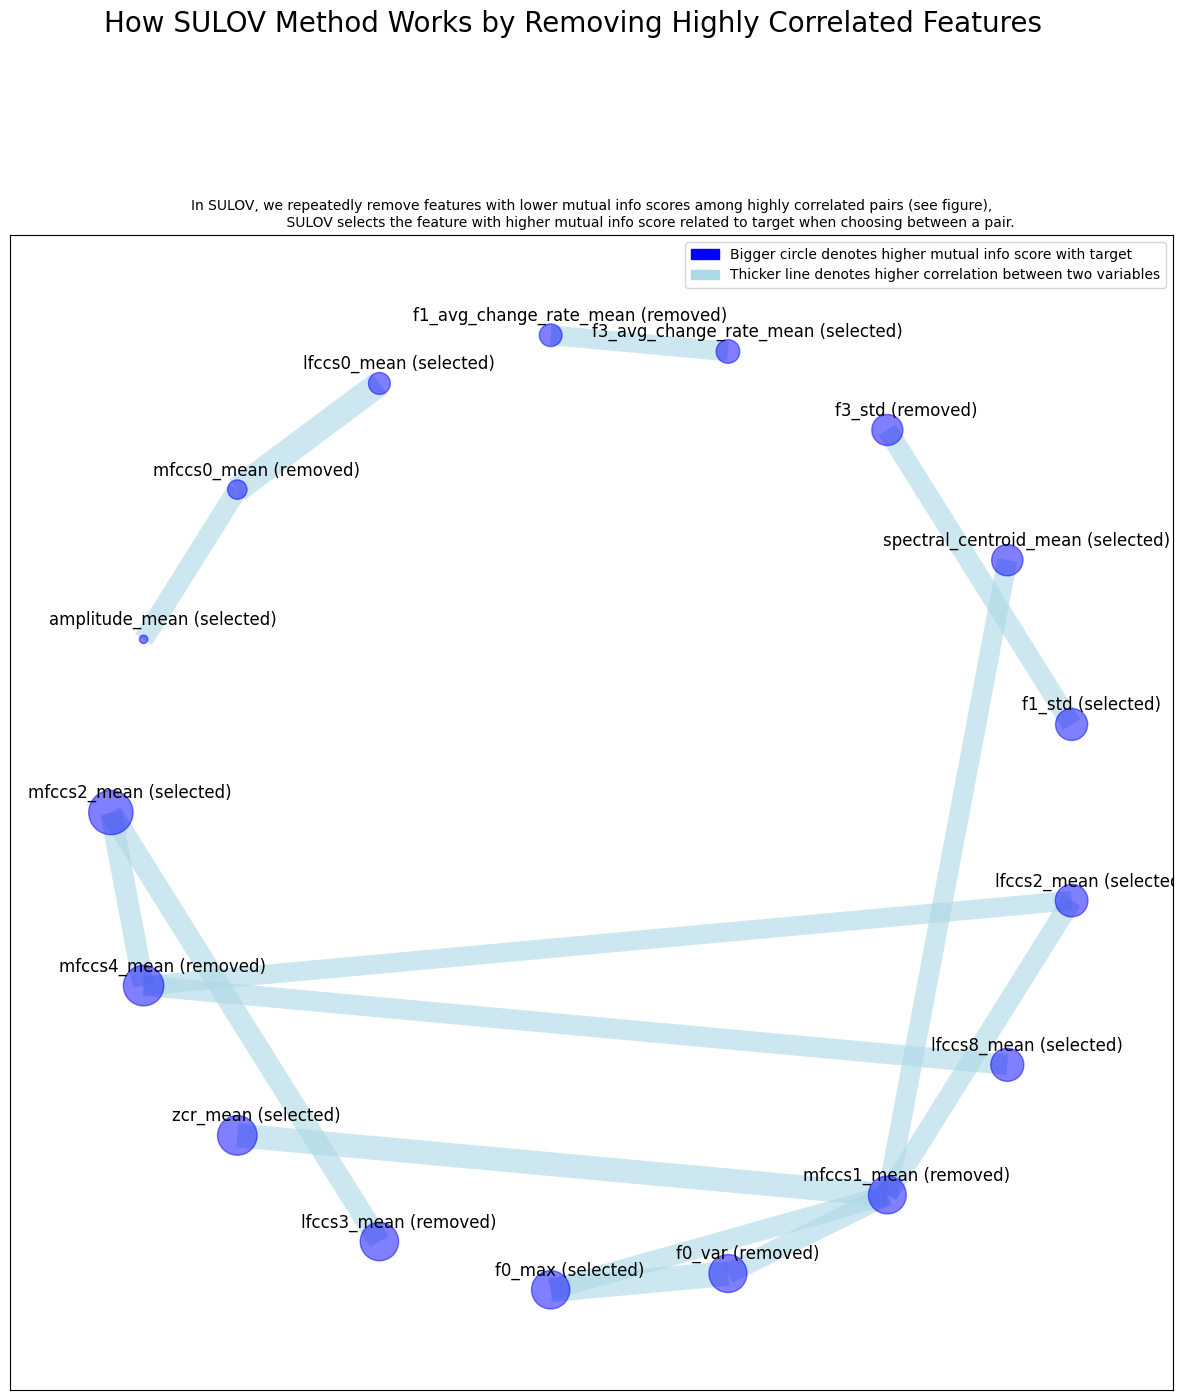

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 67
Finally 67 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 14 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
    Number of booster rounds = 100
        Selected: ['mfccs2_mean', 'mfccs5_mean', 'f1_std', 'lfccs2_mean', 'zcr_mean', 'speaking_rate', 'lfccs0_mean', 'lfccs1_mean', 'lfccs4_mean', 'mfccs6_mean', 'delta_mfccs0_mean', 'f1_mean', 'f0_max', 'mfccs3_mean']
            Time taken for regular XGBoost feature selection = 1 seconds
        Selected: ['mfccs2_mean', 'mfccs5_mean', 'f1_std', 'zcr_mean', 'l

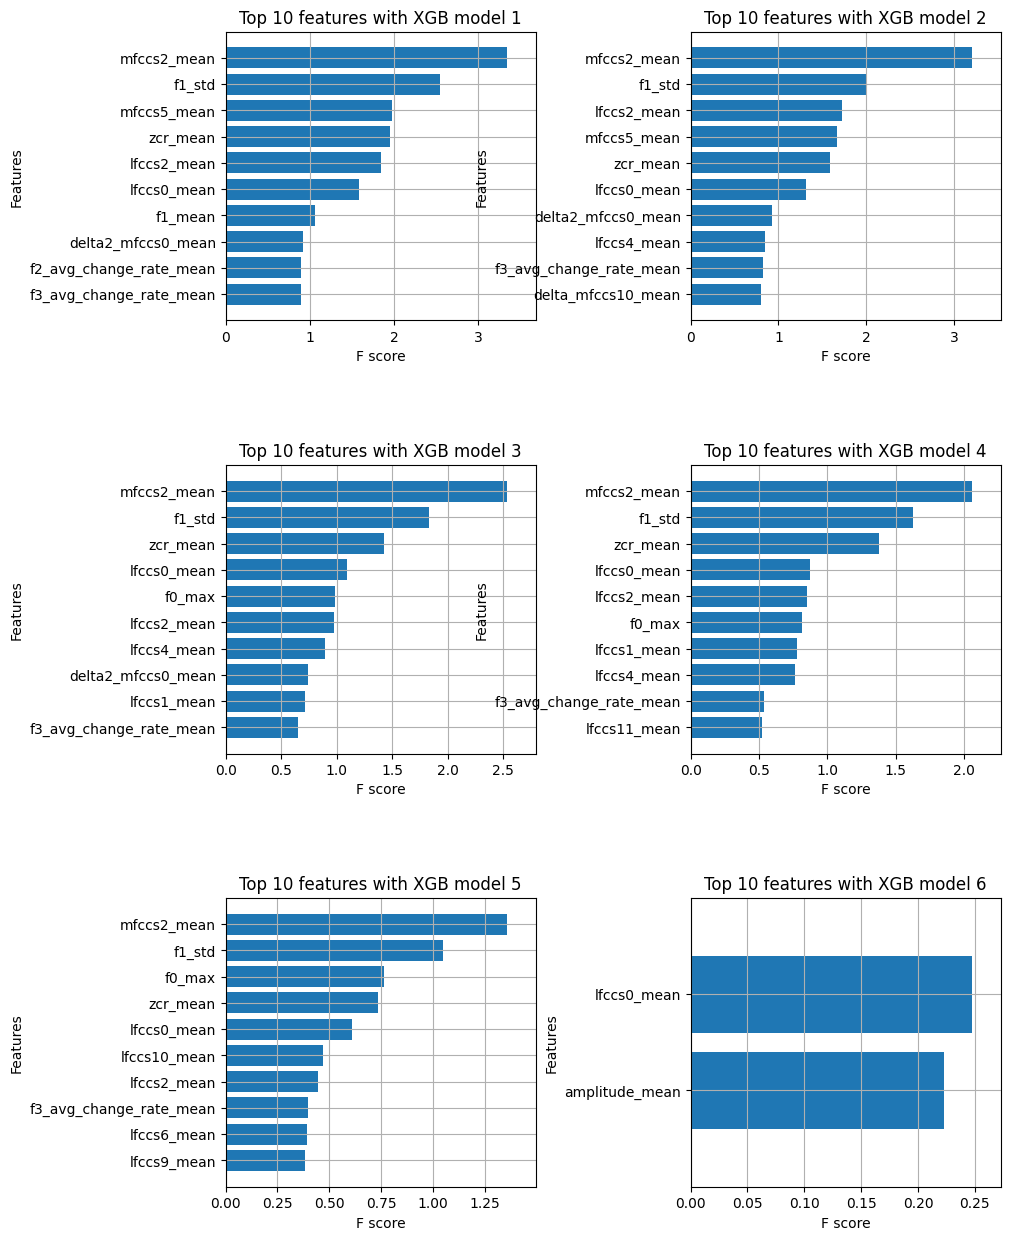

    Completed XGBoost feature selection in 3 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 27 important features:
['mfccs2_mean', 'mfccs5_mean', 'f1_std', 'lfccs2_mean', 'zcr_mean', 'speaking_rate', 'lfccs0_mean', 'lfccs1_mean', 'lfccs4_mean', 'mfccs6_mean', 'delta_mfccs0_mean', 'f1_mean', 'f0_max', 'mfccs3_mean', 'delta2_mfccs0_mean', 'mfccs8_mean', 'mfccs7_mean', 'f3_avg_change_rate_mean', 'lfccs8_mean', 'lfccs11_mean', 'delta_mfccs8_mean', 'lfccs9_mean', 'lfccs5_mean', 'spectral_centroid_mean', 'lfccs10_mean', 'lfccs6_mean', 'amplitude_mean']
Total Time taken for featurewiz selection = 8 seconds
Output contains a list of 27 important features and a train dataframe
    Time taken to create entire pipeline = 8 second(s)


In [21]:
# automatic feature selection using featurewiz package
fwiz = FeatureWiz(corr_limit=0.7, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)

X_train = fwiz.fit_transform(X_train, y_train)
X_test = fwiz.transform(X_test)

# get list of selected features
selected_features = fwiz.features 


Evaluation: f1_score
95.47% for the train data
71.64% for the test data

Evaluation: accuracy_score
95.45% for the train data
73.91% for the test data

Evaluation: precision_score
95.72% for the train data
74.85% for the test data

Evaluation: recall_score
95.26% for the train data
71.33% for the test data

Evaluation: confusion_matrix of test predictions


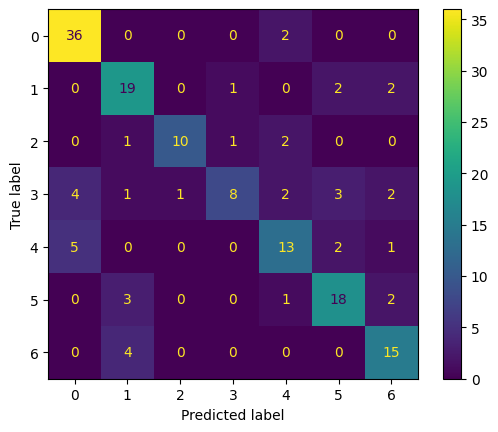


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']



In [22]:
# run best model settings with these features again
elm = skelm.ELMClassifier(pairwise_metric='euclidean', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
89.25% for the train data
68.16% for the test data

Evaluation: accuracy_score
89.57% for the train data
70.19% for the test data

Evaluation: precision_score
91.46% for the train data
71.88% for the test data

Evaluation: recall_score
87.99% for the train data
66.84% for the test data

Evaluation: confusion_matrix of test predictions


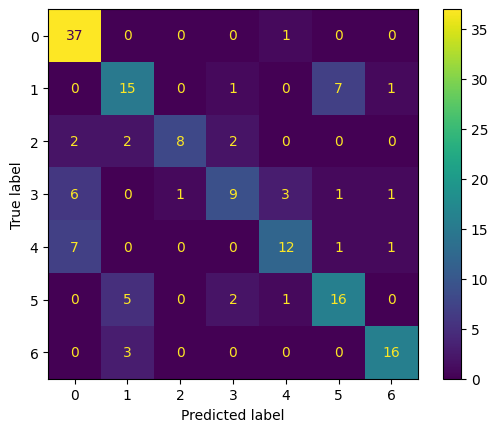


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [23]:
# compare with SVM
svm_model = SVC(random_state=0)
svm_model.fit(X_train, y_train)
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

Actually a bit worse after feature selection. Featurewiz probably selected too few features. Let's also try our the ELM model with the most important features selected by featurewiz. 

In [24]:
# load most important 215 features from featurewiz selection on 70-30 split
with open('../results/female_male_differentiation/most_important_features_70_30_split_215.pkl', 'rb') as f:
    most_imp_features = pickle.load(f)
    
df_most_important215 = df_all_stats[most_imp_features]
df_most_important215['label'] = df_all_stats['label']

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_most_important215, verbose=False, test_size=0.3)


Evaluation: f1_score
95.80% for the train data
72.57% for the test data

Evaluation: accuracy_score
95.72% for the train data
73.29% for the test data

Evaluation: precision_score
96.43% for the train data
74.04% for the test data

Evaluation: recall_score
95.54% for the train data
72.31% for the test data

Evaluation: confusion_matrix of test predictions


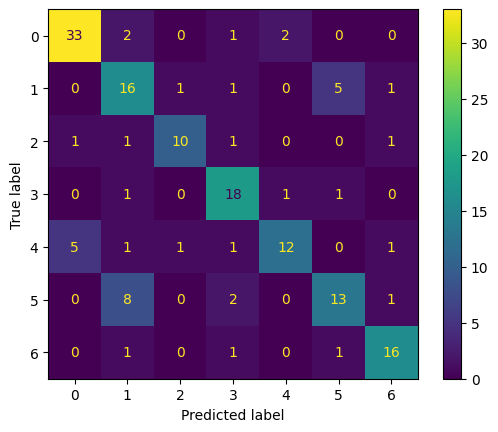


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [25]:
# run best model settings with these features again
elm = skelm.ELMClassifier(pairwise_metric='cosine', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)

# Other Models
Besides the features and models from the papers, we also want to investigate other models and find an overall best combination of features and model with highest performance measured in F1 macro.

In [26]:
# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_most_important215, verbose=False, test_size=0.3)

## Decision Tree


Evaluation: f1_score
100.00% for the train data
52.24% for the test data

Evaluation: accuracy_score
100.00% for the train data
54.66% for the test data

Evaluation: precision_score
100.00% for the train data
52.11% for the test data

Evaluation: recall_score
100.00% for the train data
52.69% for the test data

Evaluation: confusion_matrix of test predictions


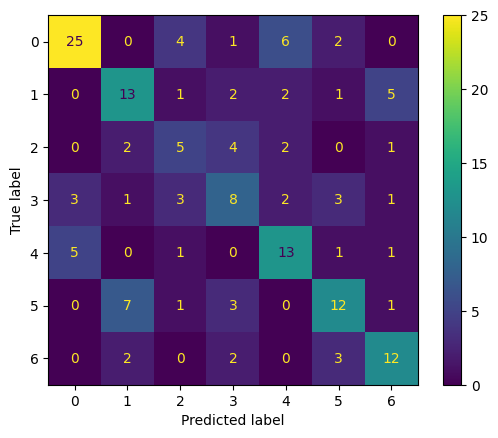


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['sadness(6)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']

Label: sadness(6)
Hard cases of false positives: ['boredom(1)']



In [27]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)
model_eval(dtc, X_train, X_test, y_train, y_test, confusion=True)

 Number of leaves: 66
 Depth of the tree: 9
 General structure of the generated tree:



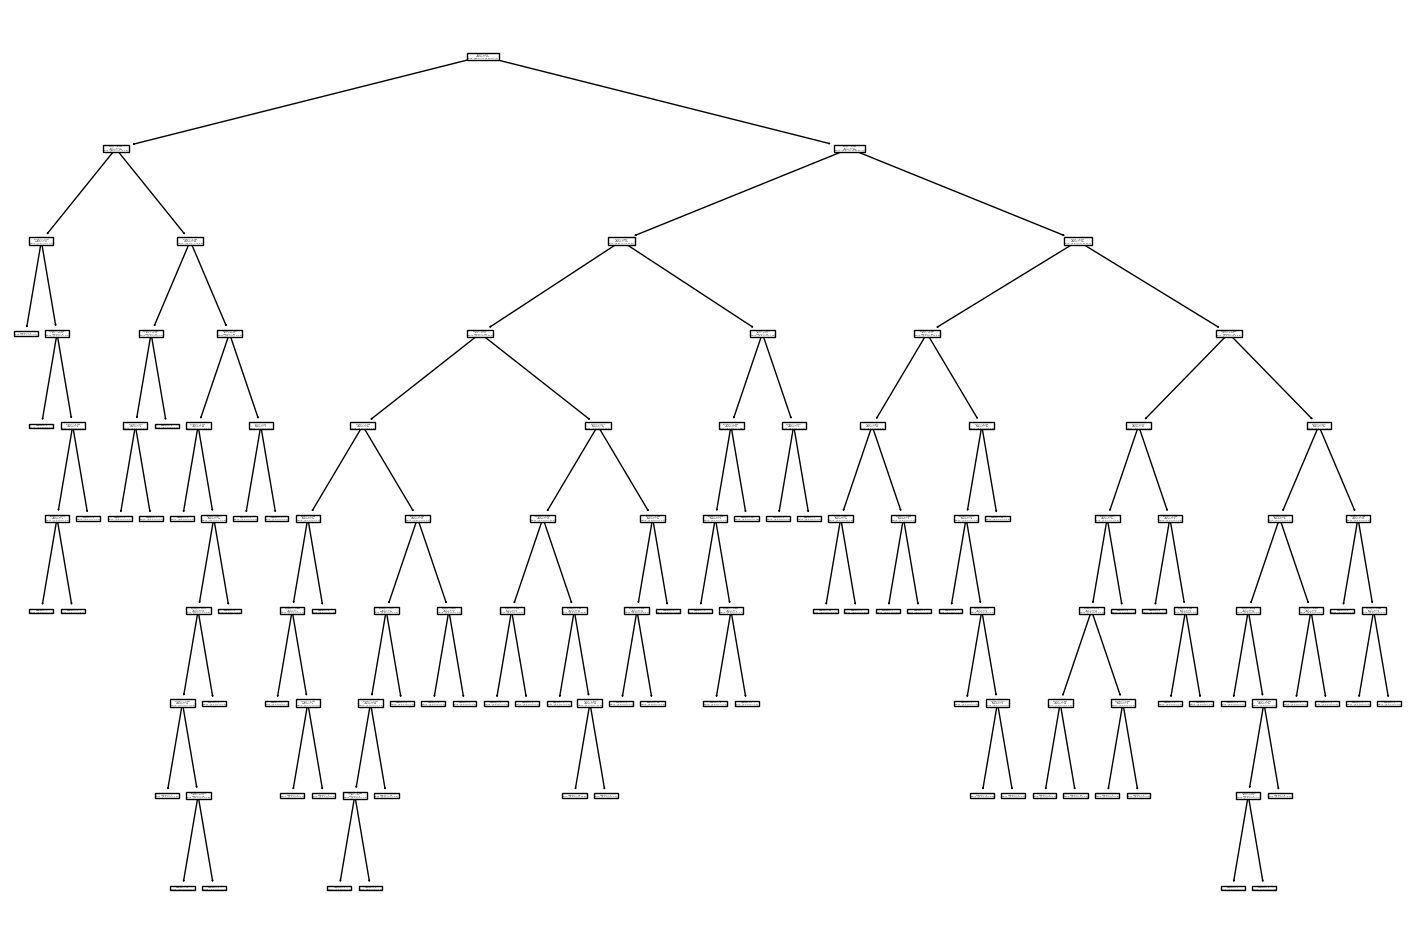

In [28]:
plt.figure(figsize=(18,12))
print(f' Number of leaves: {dtc.get_n_leaves()}\n Depth of the tree: {dtc.get_depth()}\n General structure of the generated tree:\n')
x = plot_tree(dtc)

As expected, the DecisionTreeClassifier is extremely overfitting. Let's see if a slight change of hyperparameters can improve this.

In [29]:
# define grid
decision_tree_grid = {'criterion' : ['gini', 'entropy'], 
                      'max_depth' : [5, 10, 20, 30]
                     }

In [30]:
run_gridsearchCV(dtc, decision_tree_grid, X_train, y_train, verbose=0, name_spec='fmd')


Best hyperparameters : {'criterion': 'entropy', 'max_depth': 10}
Best cross-validated f1_macro : 0.560283451866822



Evaluation: f1_score
100.00% for the train data
51.83% for the test data

Evaluation: accuracy_score
100.00% for the train data
54.04% for the test data

Evaluation: precision_score
100.00% for the train data
54.19% for the test data

Evaluation: recall_score
100.00% for the train data
51.10% for the test data

Evaluation: confusion_matrix of test predictions


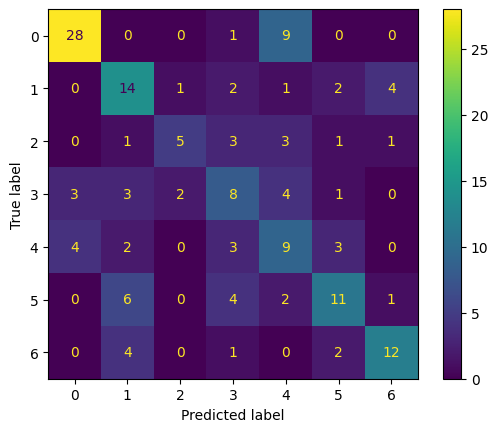


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)', 'happiness(4)']
Hard cases of false positives: ['fear(3)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [31]:
# reload the best model & evaluate
dtc_best_model = load_model('DecisionTreeClassifier', 'f1_macro' , name_spec='fmd')
model_eval(dtc_best_model, X_train, X_test, y_train, y_test, confusion=True)

 Number of leaves: 59
 Depth of the tree: 9
 General structure of the generated tree:



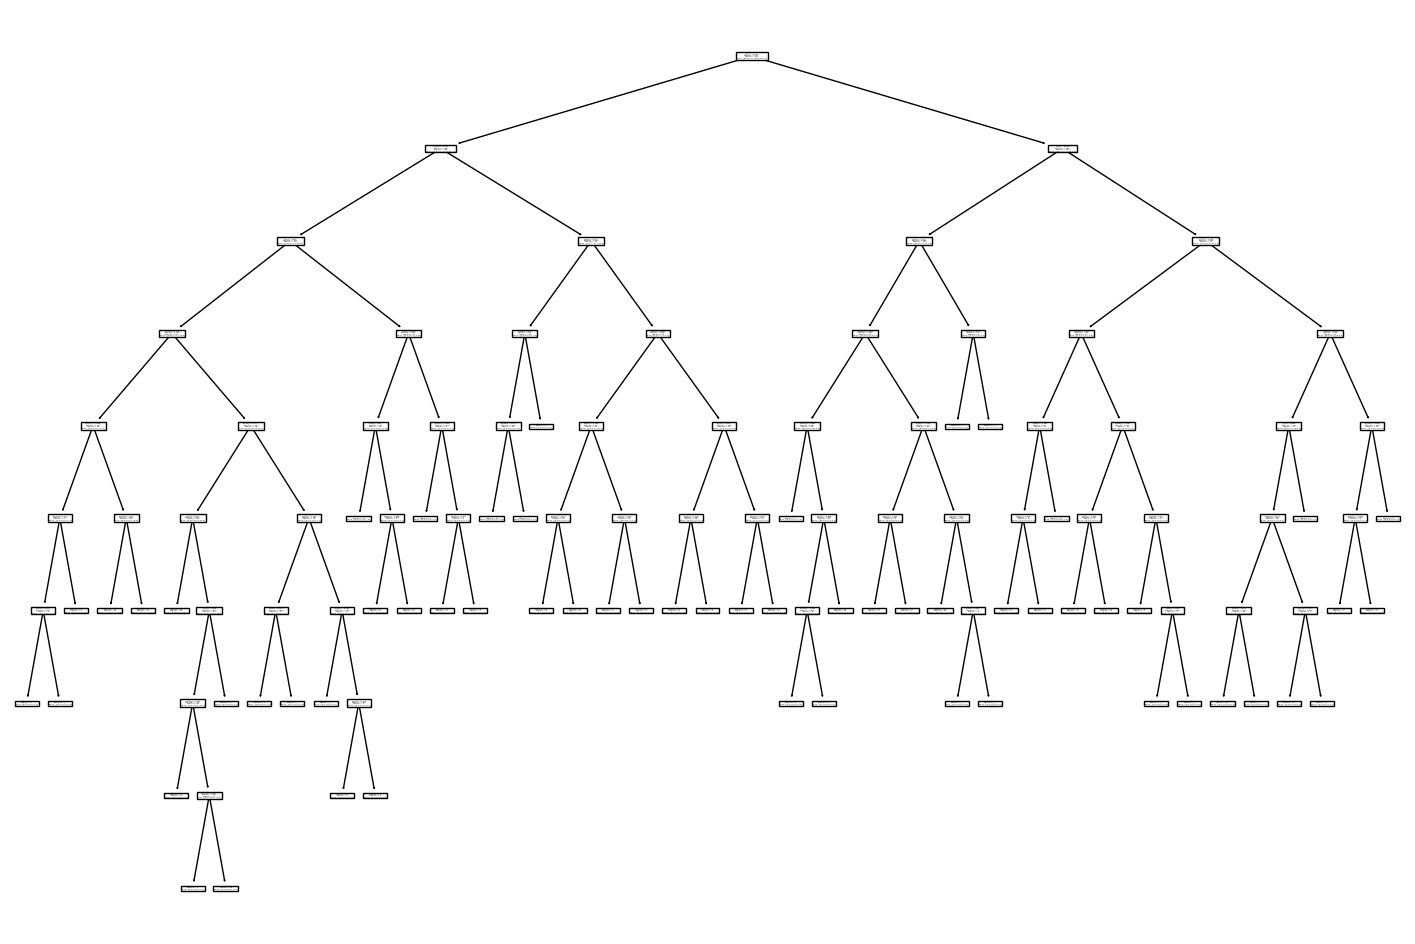

In [32]:
plt.figure(figsize=(18,12))
print(f' Number of leaves: {dtc_best_model.get_n_leaves()}\n Depth of the tree: {dtc_best_model.get_depth()}\n General structure of the generated tree:\n')
x = plot_tree(dtc_best_model)

Still bad generalization!

## Random Forest


Evaluation: f1_score
100.00% for the train data
72.76% for the test data

Evaluation: accuracy_score
100.00% for the train data
73.91% for the test data

Evaluation: precision_score
100.00% for the train data
77.31% for the test data

Evaluation: recall_score
100.00% for the train data
71.12% for the test data

Evaluation: confusion_matrix of test predictions


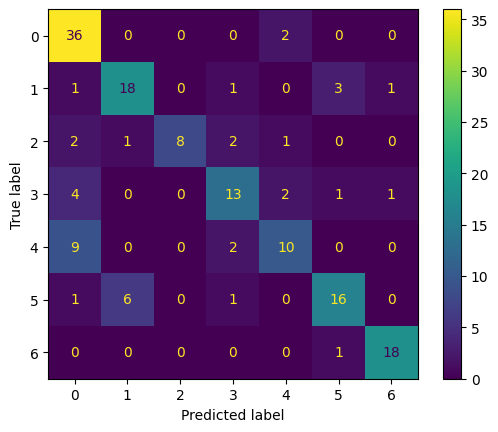


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [33]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
model_eval(rfc, X_train, X_test, y_train, y_test, confusion=True)

In [34]:
# define grid
random_forest_grid = {'n_estimators': [5, 10, 100, 200],
                      'max_depth' : [5, 10, 20, 30],
                      'bootstrap': [True, False],
                      'warm_start': [True, False]
                     }

In [35]:
run_gridsearchCV(rfc, random_forest_grid, X_train, y_train, verbose=0, name_spec='fmd')


Best hyperparameters : {'bootstrap': False, 'max_depth': 10, 'n_estimators': 200, 'warm_start': True}
Best cross-validated f1_macro : 0.7642649679741841



Evaluation: f1_score
100.00% for the train data
75.19% for the test data

Evaluation: accuracy_score
100.00% for the train data
77.02% for the test data

Evaluation: precision_score
100.00% for the train data
79.17% for the test data

Evaluation: recall_score
100.00% for the train data
74.08% for the test data

Evaluation: confusion_matrix of test predictions


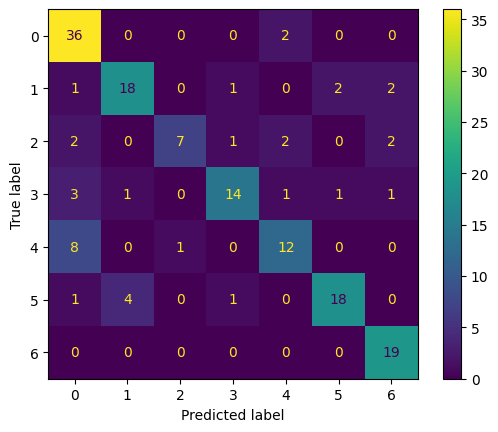


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [36]:
# reload the best model & evaluate
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro', name_spec='fmd')
model_eval(rfc_best_model, X_train, X_test, y_train, y_test, confusion=True)

## KNN Classifier


Evaluation: f1_score
83.44% for the train data
67.12% for the test data

Evaluation: accuracy_score
83.42% for the train data
69.57% for the test data

Evaluation: precision_score
85.48% for the train data
72.61% for the test data

Evaluation: recall_score
82.43% for the train data
67.35% for the test data

Evaluation: confusion_matrix of test predictions


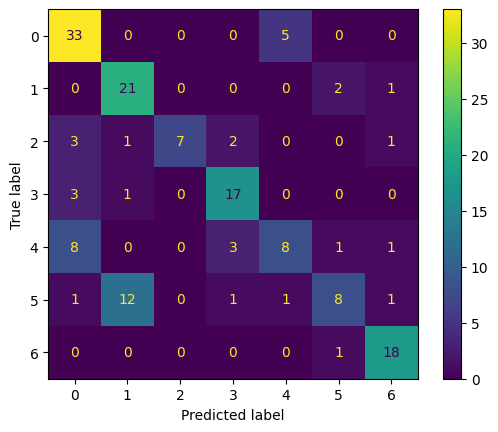


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [37]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
model_eval(knn, X_train, X_test, y_train, y_test, confusion=True)

In [38]:
# define grid
knn_grid = {'n_neighbors': [3, 4, 5, 6, 7, 8],
           'weights': ['uniform', 'distance'],
           }

In [39]:
run_gridsearchCV(knn, knn_grid, X_train, y_train, verbose=0, name_spec='fmd')


Best hyperparameters : {'n_neighbors': 8, 'weights': 'distance'}
Best cross-validated f1_macro : 0.7081912848471893



Evaluation: f1_score
100.00% for the train data
74.81% for the test data

Evaluation: accuracy_score
100.00% for the train data
74.53% for the test data

Evaluation: precision_score
100.00% for the train data
77.72% for the test data

Evaluation: recall_score
100.00% for the train data
73.85% for the test data

Evaluation: confusion_matrix of test predictions


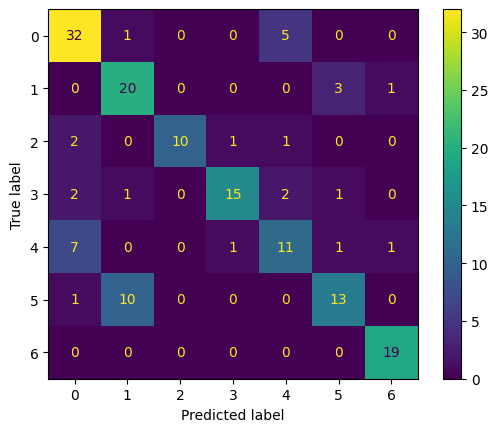


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [40]:
# reload the best model & evaluate
knn_best_model = load_model('KNeighborsClassifier', 'f1_macro', name_spec='fmd')
model_eval(knn_best_model, X_train, X_test, y_train, y_test, confusion=True)

## Naive Bayes

In [41]:
# first check if data follows a normal distribution
from scipy.stats import shapiro

looks_gaussian = []
doesntlook_gaussian = []

for feature in X_train.columns:
    stat, p = shapiro(X_train[feature])
    #print('Feature {}: Statistics = {}, p = {}'.format(feature, stat, p))
    alpha = 0.05
    if p > alpha:
        looks_gaussian.append(feature)
    else:
        doesntlook_gaussian.append(feature)

print('Feature that look Gaussian:\n{}\n'.format(looks_gaussian))
print('Feature that do not look Gaussian:\n{}'.format(doesntlook_gaussian))

Feature that look Gaussian:
['mfccs0_mean', 'lfccs3_median', 'zcr_max', 'speaking_rate', 'mfccs4_max', 'lfccs7_mean', 'delta2_mfccs3_max', 'lpc_local4_min', 'mfccs9_mean', 'amplitude_avg_change_rate_min', 'f3_avg_change_rate_max', 'lfccs11_mean', 'lfccs6_mean', 'lfccs3_max', 'mfccs9_max', 'delta_mfccs2_mean', 'delta_mfccs11_median', 'lfccs10_median', 'lfccs8_mean', 'mfccs2_max', 'delta_mfccs0_max', 'lfccs6_max', 'delta_mfccs3_median', 'f3_avg_change_rate_min', 'delta_mfccs3_mean', 'mfccs8_mean', 'lfccs0_max', 'lfccs8_max', 'f3_max', 'lpccs_local0_min', 'threshold_entropy_mean', 'mfccs3_median', 'mfccs11_min', 'mfccs7_min', 'f2_mean']

Feature that do not look Gaussian:
['rms_min', 'value_rising_pitch_iqr', 'lpc_global_mean', 'mfccs5_mean', 'f1_var', 'lpc_local4_mean', 'spectral_entropy_min', 'voiced_var', 'lfccs4_var', 'skew_log_pitch', 'delta_mfccs0_min', 'shannon_entropy_mean', 'duration_rising_pitch_max', 'delta_mfccs0_median', 'rms_max', 'lpcmfccs_local0_median', 'mfccs10_median', 


Evaluation: f1_score
88.52% for the train data
71.27% for the test data

Evaluation: accuracy_score
89.04% for the train data
71.43% for the test data

Evaluation: precision_score
88.63% for the train data
72.84% for the test data

Evaluation: recall_score
89.02% for the train data
70.77% for the test data

Evaluation: confusion_matrix of test predictions


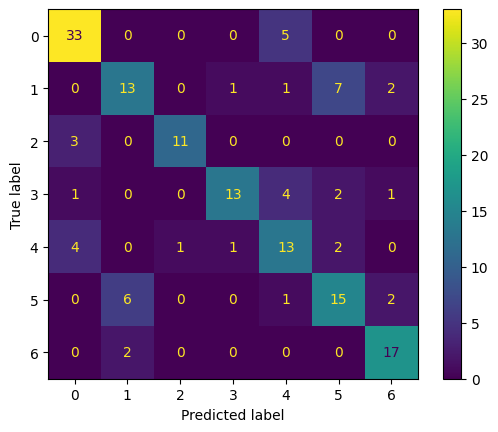


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [42]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
model_eval(gnb, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
81.44% for the train data
72.95% for the test data

Evaluation: accuracy_score
82.09% for the train data
73.29% for the test data

Evaluation: precision_score
81.75% for the train data
75.33% for the test data

Evaluation: recall_score
81.38% for the train data
72.59% for the test data

Evaluation: confusion_matrix of test predictions


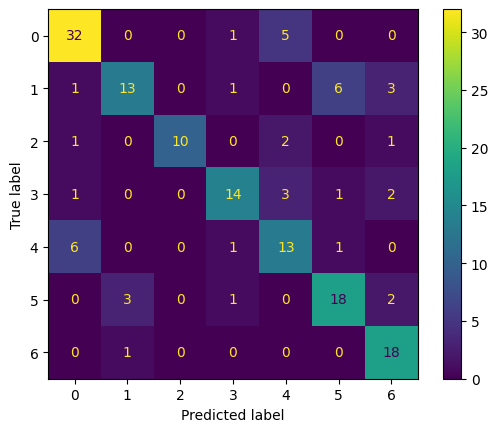


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [43]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
model_eval(bnb, X_train, X_test, y_train, y_test, confusion=True)

## XGBoost Classifier


Evaluation: f1_score
100.00% for the train data
77.76% for the test data

Evaluation: accuracy_score
100.00% for the train data
77.64% for the test data

Evaluation: precision_score
100.00% for the train data
80.53% for the test data

Evaluation: recall_score
100.00% for the train data
76.92% for the test data

Evaluation: confusion_matrix of test predictions


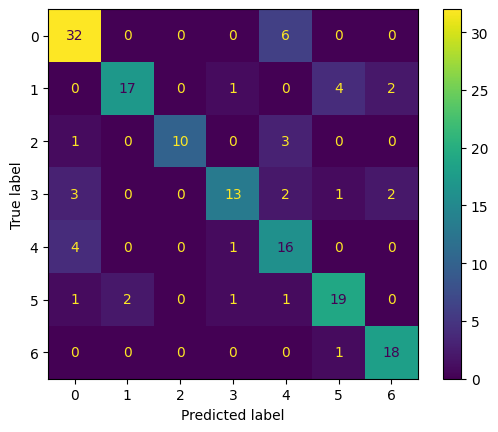


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['happiness(4)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']



In [44]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)
model_eval(xgb, X_train, X_test, y_train, y_test, confusion=True)

In [45]:
# define grid
xgb_grid = {'n_estimators': [5, 10, 100, 200, 250, 300],
            'max_depth' : [2, 5, 10, 20, 30],
            'learning_rate': [0.001, 0.01, 0.1, 0.5]
           }

In [46]:
run_gridsearchCV(xgb, xgb_grid, X_train, y_train, verbose=0, name_spec='fmd')


Best hyperparameters : {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 100}
Best cross-validated f1_macro : 0.7504080791839284



Evaluation: f1_score
100.00% for the train data
81.12% for the test data

Evaluation: accuracy_score
100.00% for the train data
80.75% for the test data

Evaluation: precision_score
100.00% for the train data
82.93% for the test data

Evaluation: recall_score
100.00% for the train data
79.97% for the test data

Evaluation: confusion_matrix of test predictions


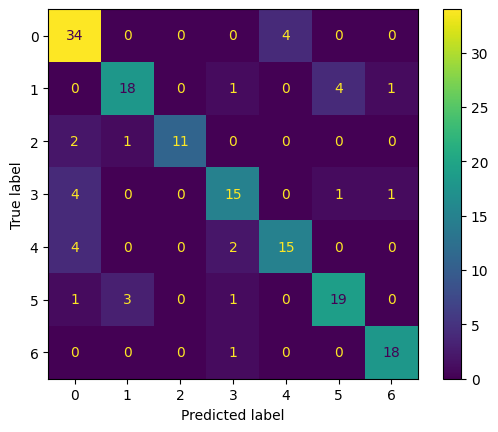


Hard cases for the model:

Label: happiness(4)
Hard cases of false positives: ['anger(0)']



In [47]:
# reload the best model & evaluate
xgb_best_model = load_model('XGBClassifier', 'f1_macro', name_spec='fmd')
model_eval(xgb_best_model, X_train, X_test, y_train, y_test, confusion=True)

## Feature Importance for other models
Models perform best with featurewiz 97 data set. Let's look at the feature importances within the different models on that data set.

In [92]:
# load most important 97 data from featurewiz selection
df_most_important97 = pd.read_pickle('../results/female_male_differentiation/df_prep_most_important97.pkl')

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_most_important97, verbose=False, test_size=0.3)

RBF kernel. Computing permutation importance.


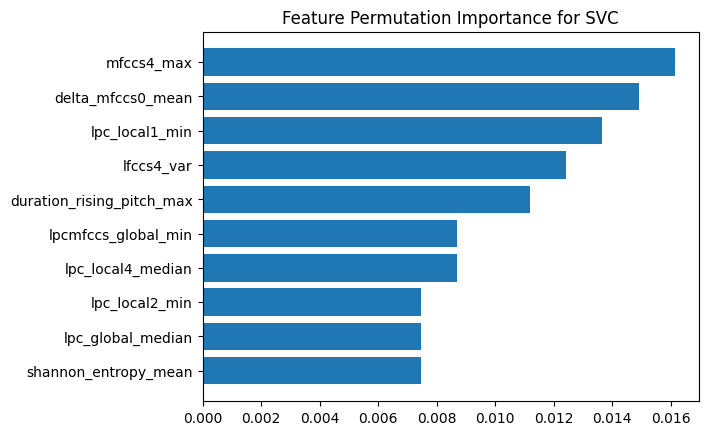

In [93]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='most_important97_fmd') # load model
feature_imp_svm = feature_importance(svm_best_model, X_test, y_test, top=10)

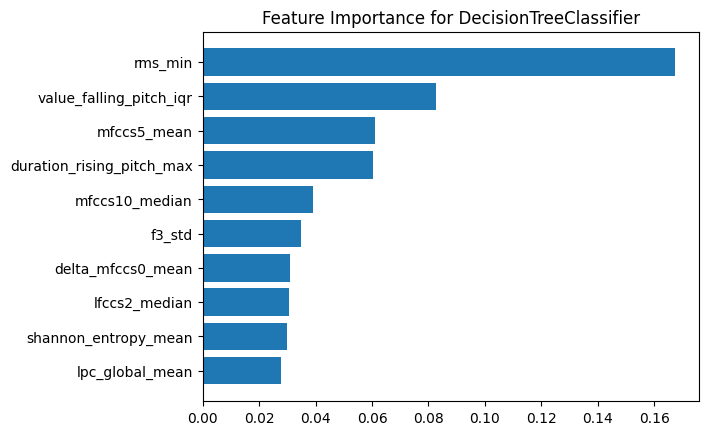

In [94]:
dtc_best_model = load_model('DecisionTreeClassifier', 'f1_macro', name_spec='fmd') # load model
feature_imp_dtc = feature_importance(dtc_best_model, X_test, y_test, top=10)

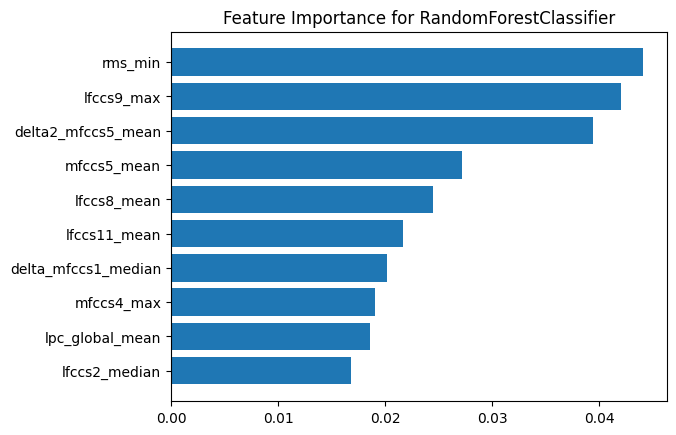

In [95]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro') # load model
feature_imp_rfc = feature_importance(rfc_best_model, X_test, y_test, top=10)

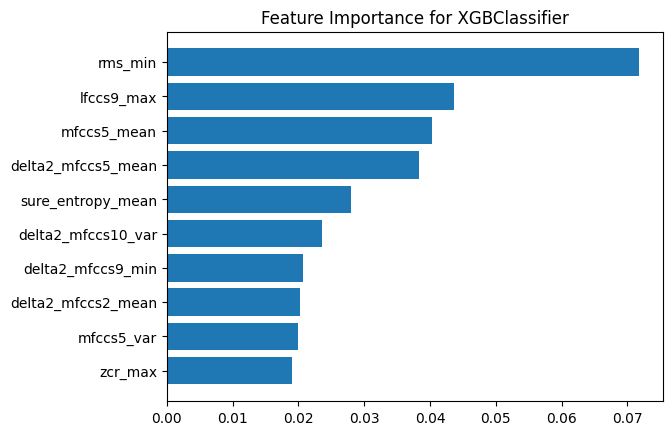

In [96]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro') # load model
feature_imp_xgb = feature_importance(xgb_best_model, X_test, y_test, top=10)